(sec-tutorial-experiment)=

# Tutorial: Running an Experiment

```{seealso}
The complete source code of this tutorial can be found in

{nb-download}`Running an Experiment.ipynb`

The example dataset can be downloaded {download}`here <../examples/dataset.hdf5>`.
```

This notebook presents a structure for setting up experiments using a
combination of `quantify-scheduler` and `quantify-core`. `quantify-scheduler`
provides a high-level interface with the hardware, allowing users to abstract
hardware-specific nuances. `quantify-core`, on the other hand, serves as an
experiment management tool, using `quantify-scheduler` as its hardware
interface. This allows users to manage, execute, and analyze experiments easily.

The following is a general workflow for using Quantify

- **{ref}`initial_setup`**
  - Set the directory for data storage for the experiment
  - Initialize the {class}`~quantify_core.measurement.control.MeasurementControl` and {class}`~quantify_scheduler.instrument_coordinator.instrument_coordinator.InstrumentCoordinator` objects

- **{ref}`device_setup`**
  - Set up a *device compilation configuration* for the *device under test*

- **{ref}`hardware_setup`**
  - Connect to the *control hardware*
  - Set up the *hardware compilation configuration*

- **{ref}`create_schedule`**
  - Create a *schedule* containing the timeline of operations for the experiment
  - *Compile* the schedule to control-hardware code
  - *Visualize* the schedule

- **{ref}`run_experiment`**
  - Setup {class}`~quantify_core.measurement.control.MeasurementControl` to run the experiment
  - *Run* the experiment
  - *Analyze* the results


(initial_setup)=
## 1. Initial Setup
We first set up the directory in which all experimental data will be stored and managed.

In [1]:
from quantify_core.data import handling as dh
dh.set_datadir()

Data will be saved in:
/root/quantify-data


Next, we need to initialize two classes:
{class}`~quantify_core.measurement.control.MeasurementControl` for managing the
experiment and {class}`~quantify_scheduler.instrument_coordinator.instrument_coordinator.InstrumentCoordinator` for managing the control hardware.

In [2]:
from quantify_core.measurement.control import MeasurementControl
from quantify_scheduler.instrument_coordinator import InstrumentCoordinator

measurement_control = MeasurementControl("measurement_control")
instrument_coordinator = InstrumentCoordinator("instrument_coordinator")

(device_setup)=
## 2. Device Setup

We set up the quantum device on which we perform the actual experiments.
This one-qubit chip is represented by {class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice` where we add a single
transmon qubit (represented by {class}`~quantify_scheduler.device_under_test.transmon_element.BasicTransmonElement`) `q0` to it.

In [3]:
# Device parameters
ACQ_DELAY = 100e-9
FREQ_01 = 4e9
READOUT_AMP = 0.1
READOUT_FREQ = 4.3e9
PI_PULSE_AMP = 0.15
LO_FREQ_QUBIT = 3.9e9
LO_FREQ_READOUT = 4.5e9

In [4]:
from quantify_scheduler.device_under_test.quantum_device import QuantumDevice
from quantify_scheduler.device_under_test.transmon_element import BasicTransmonElement

single_qubit_device = QuantumDevice("single_qubit_device")
single_qubit_device.instr_instrument_coordinator(instrument_coordinator.name)

q0 = BasicTransmonElement("q0")
single_qubit_device.add_element(q0)

# Assign device parameters to transmon element
q0.measure.pulse_amp(READOUT_AMP)
q0.clock_freqs.readout(READOUT_FREQ)
q0.clock_freqs.f01(FREQ_01)
q0.measure.acq_delay(ACQ_DELAY)
q0.rxy.amp180(PI_PULSE_AMP)

```{admonition} Quantum Devices and Elements
More information on quantum devices and elements can be found in
{ref}`sec-tutorial-ops-qubits`.
```

(hardware_setup)=
## 3. Hardware Setup

Let us now set up the connections to the control hardware. In this example, we
use a dummy Qblox device that is created via an instance of the
{class}`~qblox_instruments.Cluster` class, and is initialized with a dummy
configuration consisting of a readout module in slot `1` and a control module in
slot `2`.

In [5]:
from qblox_instruments import Cluster, ClusterType
from quantify_scheduler.instrument_coordinator.components.qblox import ClusterComponent
cluster = Cluster(
    "cluster",
    dummy_cfg={
        1: ClusterType.CLUSTER_QRM,
        2: ClusterType.CLUSTER_QCM_RF,
    },
)

ic_cluster = ClusterComponent(cluster)
instrument_coordinator.add_component(ic_cluster)

The last part of setting up the hardware is to define the {class}`~.backends.types.common.HardwareCompilationConfig`
and attach it to our `single_qubit_device`. The hardware compilation configuration is a
pydantic datastructure, parsed either from a file or from a Python
dictionary. It contains all of the information about the instruments used to run
the experiment and is used to compile the schedule to hardware.
For more information on this datastructure, please refer to the explanation in the {ref}`User Guide <sec-hardware-compilation-config>`.

In [6]:
hardware_comp_cfg = {
    "config_type": "quantify_scheduler.backends.qblox_backend.QbloxHardwareCompilationConfig",
    "hardware_description": {
        f"{cluster.name}": {
            "instrument_type": "Cluster",
            "ref": "internal",
            "modules": {
                "1": {
                    "instrument_type": "QRM_RF"
                },
                "2": {
                    "instrument_type": "QCM_RF"
                },
            },
        },
    },
    "hardware_options": {
        "modulation_frequencies": {
            "q0:res-q0.ro": {"lo_freq": LO_FREQ_READOUT},
            "q0:mw-q0.01": {"lo_freq": LO_FREQ_QUBIT},
        },
    },
    "connectivity": {
        "graph": [
            (f"{cluster.name}.{cluster.module1.name.split('_')[-1]}.complex_output_0", "q0:res"),
            (f"{cluster.name}.{cluster.module2.name.split('_')[-1]}.complex_output_0", "q0:mw")
        ]
    },
}

In [7]:
# Tie hardware config to device
single_qubit_device.hardware_config(hardware_comp_cfg)

(create_schedule)=
## 4. Schedule Definition and Compilation
Now we must create a schedule, where we define the set of operations that we
wish to perform on the device under test. We define the schedule independent of
the hardware configuration and rely on Quantify's ability to compile a schedule
to hardware for converting it to hardware-level commands. For this tutorial, we
will define a simple schedule that will run a *T1 experiment* to determine the
relaxation time of our qubit. For various delay times `tau`, we repeatedly
excite the qubit, wait `tau` seconds and then measure the qubit.

In [8]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations.gate_library import Measure, Reset, X

def t1_sched(times, repetitions=1):
    schedule = Schedule("T1", repetitions)
    for i, tau in enumerate(times):
        schedule.add(Reset("q0"), label=f"Reset {i}")
        schedule.add(X("q0"), label=f"pi {i}")
        schedule.add(
            Measure("q0", acq_index=i),
            ref_pt="start",
            rel_time=tau,
            label=f"Measurement {i}",
        )
    return schedule

```{admonition} Pre-defined Schedules
:class: tip

The T1 schedule can be imported with `from quantify_scheduler.schedules import t1_sched`.

For more pre-defined schedules, see {mod}`quantify_scheduler.schedules`.
```

We can inspect the details of the schedule in three different ways: via (1)
*circuit* and (2) *pulse diagrams*, or through (3) a *timing table* containing the
timing and other information of each operation.

The
{meth}`~quantify_scheduler.schedules.schedule.ScheduleBase.plot_circuit_diagram`
method can directly be used to display the quantum circuit that corresponds to
the schedule that we defined above.

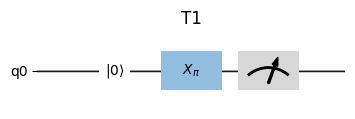

In [9]:
t1_schedule = t1_sched(times=[1e-6])
t1_schedule.plot_circuit_diagram();

For displaying the pulse diagram and timing table, the schedule first needs to get timing information for each operation in the schedule. This is achieved by compiling the schedule using {class}`~quantify_scheduler.backends.graph_compilation.SerialCompiler`. Please note that below in section {ref}`run_experiment`, the compilation is handled by {class}`~quantify_core.measurement.control.MeasurementControl` internally; it is done here only to enable displaying the timing table and pulse diagram.

```{admonition} Compiling to Hardware
More information on compilation can be found in {ref}`sec-tutorial-compiling`.
```

In [10]:
from quantify_scheduler.backends.graph_compilation import SerialCompiler

compiler = SerialCompiler(name="compiler", quantum_device=single_qubit_device)
compiled_schedule = compiler.compile(schedule=t1_schedule)

Each operation is compiled into pulses that can be viewed and inspected via the {meth}`~quantify_scheduler.schedules.schedule.ScheduleBase.plot_pulse_diagram` method.

In [11]:
compiled_schedule.plot_pulse_diagram(plot_backend="plotly")

By passing the `plotly` backend, we made the above diagram interactive.


Lastly, the timing table can simply be accessed via the {attr}`~quantify_scheduler.schedules.schedule.ScheduleBase.timing_table` property of a schedule.

In [12]:
compiled_schedule.timing_table

```{admonition} Device-layer Schedules (Pulses)
More information on defining schedules using pulses can be found in {ref}`sec-tutorial-sched-pulse`.
```

```{admonition} Circuit-layer Schedules (Gates and Measurements)
More information on defining schedules using circuit-layer operations and mixing with
pulses can be found in {ref}`sec-tutorial-ops-qubits`.
```

(run_experiment)=
## 5. Experiment Execution and Analysis

We can now configure our {class}`~quantify_core.measurement.control.MeasurementControl` to run the experiment. In
this case, we will perform a 1-dimensional sweep using a
{class}`qcodes.instrument.parameter.ManualParameter`. Sweeping such a parameter will physically change the hardware output as the sweep is performed.

In [13]:
import numpy as np
from qcodes.instrument.parameter import ManualParameter
from quantify_scheduler.gettables import ScheduleGettable

# Configure the settable
time = ManualParameter("sample", label="Sample time", unit="s")
time.batched = True

times = np.linspace(start=1.6e-7, stop=4.976e-5, num=125)

# Configure the gettable
gettable = ScheduleGettable(
    quantum_device=single_qubit_device,
    schedule_function=t1_sched,
    schedule_kwargs={"times": times},
    batched=True
)

# Configure MeasurementControl
measurement_control.settables(time)
measurement_control.setpoints(times)
measurement_control.gettables(gettable)

In the above example, we use
{meth}`~quantify_core.measurement.control.MeasurementControl.settables` and
{meth}`~quantify_core.measurement.control.MeasurementControl.gettables` together
with `batched=True` to instruct `measurement_control` how to execute the
experiment. Instead of iteratively processing each value in the `times` array, all are
processed in one batch.

```{admonition} Configuring MeasurementControl
More information on configuring {class}`~quantify_core.measurement.control.MeasurementControl` can be found in the
[user guide](https://quantify-os.org/docs/quantify-core/dev/user/concepts.html#measurement-control)
of `quantify-core`.
```

Once {class}`~quantify_core.measurement.control.MeasurementControl` is all set
up, we can run the experiment.

In [14]:
dataset = measurement_control.run()

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 sample 
Batch size limit: 125



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

The result of the experiment is assigned to the variable `dataset`, but also saved to disk (as set by {func}`~quantify_core.data.handling.set_datadir` at the start of this tutorial).

To analyze the experiment results, we can choose from the variety of classes from the {mod}`quantify_core.analysis`
package. For a T1 experiment, we use the
{class}`~quantify_core.analysis.single_qubit_timedomain.T1Analysis` class which
is used to fit the data, extract relevant parameters and visualize the result.
In this tutorial, we run the experiment on a dummy cluster, and therefore the
dataset that we obtain is empty. For demonstrational purposes, we show how it
would look on an actual dataset. This example dataset can be downloaded
{download}`here <../examples/dataset.hdf5>`.

In [15]:
import xarray

dataset = xarray.open_dataset("../examples/dataset.hdf5")

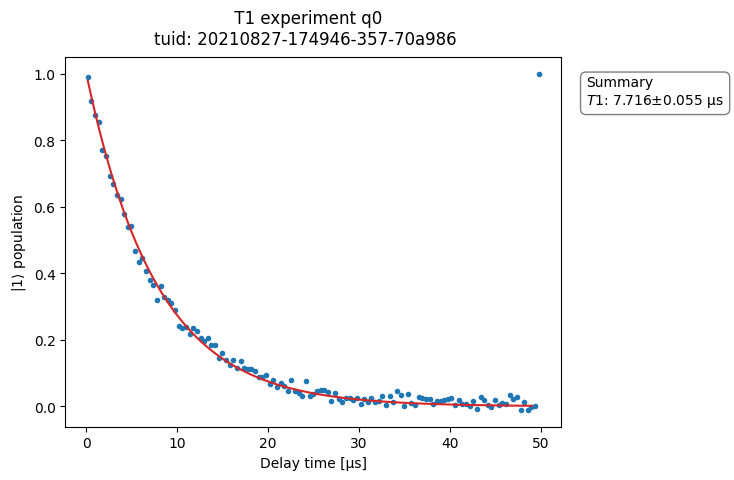

In [16]:
from quantify_core.analysis import T1Analysis

T1Analysis(dataset=dataset).run().display_figs_mpl()

```{admonition} Analyzing Datasets
More information on analyzing datasets can be found in the [user guide](
<https://quantify-os.org/docs/quantify-core/dev/user/concepts.html#analysis>)
of `quantify-core`.
```